In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('sentiwordnet')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk import pos_tag, pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import sent_tokenize, word_tokenize, pos_tag
import seaborn as sns
import re
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_restaurant_businesses= pd.read_pickle("df_restaurant_businesses.pkl")

In [4]:
df_restaurant_businesses.shape

(6012, 6)

In [5]:
df_restaurant_businesses.columns

Index(['number of businesses', 'city', 'state', 'stars', 'review_count',
       'categories'],
      dtype='object')

In [6]:
df_restaurant_businesses.dropna(axis=0, how='any', inplace = True) #drop rows with null values

In [7]:
df_restaurant_businesses=df_restaurant_businesses.rename(columns={'number of businesses':'business_id'})
df_restaurant_businesses.columns

Index(['business_id', 'city', 'state', 'stars', 'review_count', 'categories'], dtype='object')

In [8]:
df_restaurant_reviews= pd.read_pickle("df_restaurant_reviews.pkl")

In [9]:
df_restaurant_reviews.shape

(107128, 6)

In [10]:
df_restaurant_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text'], dtype='object')

In [11]:
df_restaurant_reviews=df_restaurant_reviews[['business_id','stars', 'text']]

In [12]:
df_restaurant_reviews.columns

Index(['business_id', 'stars', 'text'], dtype='object')

## Cleaning, Preprocessing and lemmatization of data

Summary:

1) Clean the text by trimming, replacing extra characters, converting text to lowercase.

2) Tokenize text to sentences and then to word.

3) Tag all the words with POS

4) Convert tags to wordnet tags

5) Lemmatize all the words and create sysnets

6) Calculate sentiment score using sentiwordnet from nltk corpus

7) Return a polarity score

(How do you find the polarity of a sentence?

The polarity of words is retrieved from the package pattern and the sentence polarity is calculated using: Sum of polarity of all the words in a sentence divided by the total number of words in the sentence

In [13]:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()

def convert_tag(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def clean_text(text):
    text = text.replace("<br />", " ")
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text


def compute_polarity_score(text):
    sentiment_score = 0.0
    text = clean_text(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tagged_sentence = pos_tag(word_tokenize(sentence))
        for word, tag in tagged_sentence:
            wn_tag = convert_tag(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_score += swn_synset.pos_score() - swn_synset.neg_score()
    # sum greater than 0 => positive sentiment
    if sentiment_score >= 0:
        return 1
    # All other scenarios => negative sentiment
    else:
        return 0
 

# Sentiment Analysis on Yelp Reviews

In [15]:
# Creating new column polarity which has polarity score of each review in reviews dataframe 
df_restaurant_reviews['polarity']=df_restaurant_reviews['text'].apply(compute_polarity_score)

In [16]:
# Writing to pickle for a backup
df_restaurant_reviews.to_pickle("after polarity calculation df_restaurant_reviews.pkl")
# df_restaurant_reviews=pd.read_pickle("after polarity calculation df_restaurant_reviews.pkl")

In [17]:
df_restaurant_reviews.head()

,business_id,stars,text,polarity
32,LkMtMHVetws5_7QfRjPtlg,2,This actually used to be one of my favorite ho...,0
186,38YPE4KCvgChy9y6FcksEQ,2,The pizza wasn't very warm when it arrived (th...,1
507,ID5wWJ9C7G0hfbQilvlfxA,1,I've been here several times over the last 3 y...,1
633,rcaPajgKOJC2vo_l3xa42A,4,Loved the Bakery.. Finally decided to try the ...,1
699,Os1n1_idfw9vv9kwULGJnQ,4,Good food all around. The meal begins with com...,1


In [18]:
df_restaurant_reviews.shape

(107128, 4)

In [19]:
# Now we will calculate the net positive sentiment score for each business as follows: 
# net_positive_sentiment_score = sum(polarity) / total_count_of_reviews 
# sum(polarity) for each business can be aggregated and obtained from df_restaurant_reviews dataframe 
# total_count_of_reviews is already available in df_restaurant_businesses dataframe (review_count) column
df_restaurant_reviews=df_restaurant_reviews.groupby('business_id').mean().reset_index()
df_restaurant_reviews=df_restaurant_reviews[['business_id','polarity']]
df_restaurant_reviews.rename(columns={'polarity':'overall_positive_sentiment_score'}, inplace=True)

In [20]:
df_restaurant_reviews.shape

(6012, 2)

In [21]:
df_restaurant_businesses.shape

(6012, 6)

In [22]:
df_restaurant_businesses.columns

Index(['business_id', 'city', 'state', 'stars', 'review_count', 'categories'], dtype='object')

In [23]:
data = pd.merge(df_restaurant_businesses, df_restaurant_reviews, on='business_id', how='inner')    
data.shape
data.columns

Index(['business_id', 'city', 'state', 'stars', 'review_count', 'categories',
       'overall_positive_sentiment_score'],
      dtype='object')

In [24]:
data=data[['business_id','stars','overall_positive_sentiment_score']]

In [25]:
data.head()

,business_id,stars,overall_positive_sentiment_score
0,fnZrZlqW1Z8iWgTVDfv_MA,2.5,1.00
1,fhNf_sg-XzZ3e7HEVGuOZg,3.0,0.75
2,OWkS1FXNJbozn-qPg3LWxg,4.5,1.00
3,MTx-Zdl_KcU_z9G832XAjg,2.5,1.00
4,Q_dh08clYUPj13GmCRzIVA,4.0,0.75


## Sentiment Analysis on Yelp Tips

In [ ]:
df_yelp_tips=pd.read_json("yelp_academic_dataset_tip.json",encoding='utf8',lines=True)

In [ ]:
df_yelp_tips=df_yelp_tips[['business_id', 'text']]

In [ ]:
df_yelp_tips.shape

In [ ]:
df_yelp_tips=df_yelp_tips[df_yelp_tips['business_id'].isin(df_restaurant_businesses['business_id'])]

In [ ]:
df_yelp_tips.shape

In [ ]:
df_yelp_tips.columns

In [ ]:
# Creating new column polarity which has polarity score of each tip in tips dataframe 
df_yelp_tips['polarity'] = df_yelp_tips['text'].apply(compute_polarity_score)

In [45]:
df_yelp_tips.to_pickle("after polarity calculation df_yelp_tips.pkl")
# df_yelp_tips=pd.read_pickle("after polarity calculation df_yelp_tips.pkl")

In [46]:
temp_tips=df_yelp_tips

In [47]:
df_yelp_tips.head()

,business_id,text,polarity
1,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,0
3,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,0
4,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",1
6,d_L-rfS1vT3JMzgCUGtiow,Cochinita Pibil was memorable & delicious !,1
8,rcaPajgKOJC2vo_l3xa42A,Kelly is an awesome waitress there!,1


In [48]:
df_yelp_tips.shape

(296846, 3)

In [49]:
df_yelp_tips=df_yelp_tips.groupby('business_id').mean().reset_index()
df_yelp_tips=df_yelp_tips[['business_id','polarity']]
df_yelp_tips.rename(columns={'polarity':'overall_positive_sentiment_score_tips'}, inplace=True)

In [50]:
df_yelp_tips.head()

,business_id,overall_positive_sentiment_score_tips
0,--9e1ONYQuAa-CB_Rrw7Tw,0.880682
1,-0RkJ_uIduNLWQrphbADRw,0.785714
2,-1m9o3vGRA8IBPNvNqKLmA,0.909091
3,-1vfRrlnNnNJ5boOVghMPA,0.560000
4,-2nfJ8yK54A7Md2RzmMR4g,1.000000


In [51]:
data.shape

(6012, 4)

In [52]:
data.columns

Index(['business_id', 'stars', 'overall_positive_sentiment_score',
       'sentiment'],
      dtype='object')

In [53]:
data = pd.merge(data, df_yelp_tips , on='business_id', how='left')
data=data.fillna(0)

In [54]:
data.shape

(6012, 5)

In [55]:
data.columns

Index(['business_id', 'stars', 'overall_positive_sentiment_score', 'sentiment',
       'overall_positive_sentiment_score_tips'],
      dtype='object')

## Extracting check-ins data

In [57]:
df_checkins= pd.read_json("yelp_academic_dataset_checkin.json",encoding='utf8',lines=True)

In [58]:
df_checkins.shape

(175187, 2)

In [59]:
df_checkins.columns

Index(['business_id', 'date'], dtype='object')

In [60]:
df_checkins=df_checkins[df_checkins['business_id'].isin(df_restaurant_businesses['business_id'])]

In [61]:
df_checkins.shape

(5923, 2)

In [62]:
df_checkins['temp']=df_checkins['date'].str.split(',')

In [63]:
# Counting check-ins count for each business
df_checkins['count']=df_checkins.temp.apply(lambda x: len(x))

In [64]:
df_checkins=df_checkins.rename(columns={'count':'check-ins'})

In [65]:
df_checkins.head()

,business_id,date,temp,check-ins
5,--9e1ONYQuAa-CB_Rrw7Tw,"2010-02-08 05:56:47, 2010-02-15 04:47:42, 2010...","[2010-02-08 05:56:47, 2010-02-15 04:47:42, 2...",2942
71,-0RkJ_uIduNLWQrphbADRw,"2018-08-30 16:32:18, 2018-09-01 19:39:03, 2018...","[2018-08-30 16:32:18, 2018-09-01 19:39:03, 2...",181
122,-1m9o3vGRA8IBPNvNqKLmA,"2017-10-25 00:48:29, 2017-10-26 02:31:11, 2017...","[2017-10-25 00:48:29, 2017-10-26 02:31:11, 2...",529
127,-1vfRrlnNnNJ5boOVghMPA,"2013-01-23 04:40:26, 2013-01-29 01:47:37, 2013...","[2013-01-23 04:40:26, 2013-01-29 01:47:37, 2...",164
174,-2nfJ8yK54A7Md2RzmMR4g,"2019-08-25 03:23:29, 2019-08-27 18:49:03, 2019...","[2019-08-25 03:23:29, 2019-08-27 18:49:03, 2...",4


In [66]:
df_checkins=df_checkins[['business_id','check-ins']]

In [67]:
df_checkins.shape

(5923, 2)

In [68]:
data = pd.merge(data, df_checkins, on='business_id', how='left')
data=data.fillna(0)

In [69]:
data.head()

,business_id,stars,overall_positive_sentiment_score,sentiment,overall_positive_sentiment_score_tips,check-ins
0,fnZrZlqW1Z8iWgTVDfv_MA,2.5,1.00,neutral,0.888889,141.0
1,fhNf_sg-XzZ3e7HEVGuOZg,3.0,0.75,neutral,0.600000,17.0
2,OWkS1FXNJbozn-qPg3LWxg,4.5,1.00,positive,1.000000,3.0
3,MTx-Zdl_KcU_z9G832XAjg,2.5,1.00,neutral,0.789474,320.0
4,Q_dh08clYUPj13GmCRzIVA,4.0,0.75,positive,0.909091,115.0


## Convert Star Ratings to Sentiments

In [26]:
# positive :: stars >= 3.5
# neutral :: stars 2.0 < x < 3.5
# negative :: stars <= 2.0
def convert_stars_to_category(data):
    if data['stars'] >= 3.5:
        return 'positive'
    elif data['stars'] <= 2.0:
        return 'negative'
    else:
        return 'neutral'
    
data['sentiment'] = data.apply(convert_stars_to_category, axis=1)

In [27]:
data.head()

,business_id,stars,overall_positive_sentiment_score,sentiment
0,fnZrZlqW1Z8iWgTVDfv_MA,2.5,1.00,neutral
1,fhNf_sg-XzZ3e7HEVGuOZg,3.0,0.75,neutral
2,OWkS1FXNJbozn-qPg3LWxg,4.5,1.00,positive
3,MTx-Zdl_KcU_z9G832XAjg,2.5,1.00,neutral
4,Q_dh08clYUPj13GmCRzIVA,4.0,0.75,positive


## Creating data matrix and labels

In [28]:
x = data[['overall_positive_sentiment_score']]
x.head()

,overall_positive_sentiment_score
0,1.00
1,0.75
2,1.00
3,1.00
4,0.75


In [29]:
y = data[['sentiment']].values.ravel()
y

array(['neutral', 'neutral', 'positive', ..., 'positive', 'positive',
       'neutral'], dtype=object)

In [30]:
#Need to plot the graph for classifiers vs accuracies
classifiers = []
accuracies = []

In [31]:
#Split the data into 70-30 parts
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

   ## Evaluation function for predicted and actual sentiment data

In [32]:
def evaluation(y_train,pred_train,y_test,pred_test,classifier):
      avg=None
      print("Evaluations for ",classifier)
      metric = pd.DataFrame([[0]*4]*2,columns=['PRECISION','RECALL','F1_SCORE','ACCURACY'],index=['Train','Test'],dtype='float32')
      metric['PRECISION']['Train'] = np.mean(precision_score(pred_train, y_train, average=avg,labels=np.unique(pred_train)))
      metric['RECALL']['Train'] = np.mean(recall_score(pred_train, y_train, average=avg,labels=np.unique(pred_train)))
      metric['F1_SCORE']['Train'] = np.mean(f1_score(pred_train, y_train, average=avg,labels=np.unique(pred_train)))
      metric['ACCURACY']['Train'] = accuracy_score(pred_train, y_train)
      metric['PRECISION']['Test'] = np.mean(precision_score(pred_test, y_test, average=avg,labels=np.unique(pred_test)))
      metric['RECALL']['Test'] = np.mean(recall_score(pred_test, y_test, average=avg,labels=np.unique(pred_test)))
      metric['F1_SCORE']['Test'] = np.mean(f1_score(pred_test, y_test, average=avg,labels=np.unique(pred_test)))
      metric['ACCURACY']['Test'] = accuracy_score(pred_test, y_test)
      print(metric)

## SVM using RBF kernels

In [33]:
clf = svm.SVC(kernel = 'rbf', C = 100) 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('RBF_svm')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"SVM Classifier")

Evaluations for  SVM Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train        1.0  0.683460  0.811971  0.683460
Test         1.0  0.670177  0.802522  0.670177


## Decision Tree

In [34]:
clf = tree.DecisionTreeClassifier(max_depth = 5) 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('DecisionTree')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Decision Tree Classifier")

Evaluations for  Decision Tree Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.581916  0.585387  0.561818  0.694629
Test    0.564433  0.559370  0.537053  0.673503


## Logistic Regression

In [35]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('LR')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Logistic Regression")

Evaluations for  Logistic Regression
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.534271  0.542461  0.490896  0.683460
Test    0.518712  0.499899  0.463668  0.661863


## Gaussian Naive Bayes

In [36]:
clf = GaussianNB() 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('GaussNB')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Gaussian Naive Bayes Classifier")

Evaluations for  Gaussian Naive Bayes Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.546935  0.554206  0.511936  0.686549
Test    0.530054  0.514057  0.485186  0.663526


## K-Nearest Neighbors 

In [37]:
clf = KNeighborsClassifier(n_neighbors=5)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('KNN')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"KNN Classifier")

Evaluations for  KNN Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.449935  0.486104  0.429482  0.680371
Test    0.417442  0.439991  0.398259  0.651330


## Random Forest

In [39]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('RandomForest')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Random Forest Classifier")

Evaluations for  Random Forest Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.545370  0.608208  0.503982  0.694867
Test    0.542614  0.600657  0.495466  0.681264


## AdaBoost

In [40]:
clf = AdaBoostClassifier()
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('AdaBoost')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Ada Boost Classifier")

Evaluations for  Ada Boost Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.573731  0.565354  0.551991  0.686787
Test    0.570080  0.560108  0.545077  0.672949


## Multi-layer perceptron

In [41]:
clf = MLPClassifier(alpha=1, max_iter=1000)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('MLPerceptron')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Multi-layer Perceptron Classifier")

Evaluations for  Multi-layer Perceptron Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.532220  0.538570  0.487455  0.682747
Test    0.518452  0.501989  0.462482  0.662417


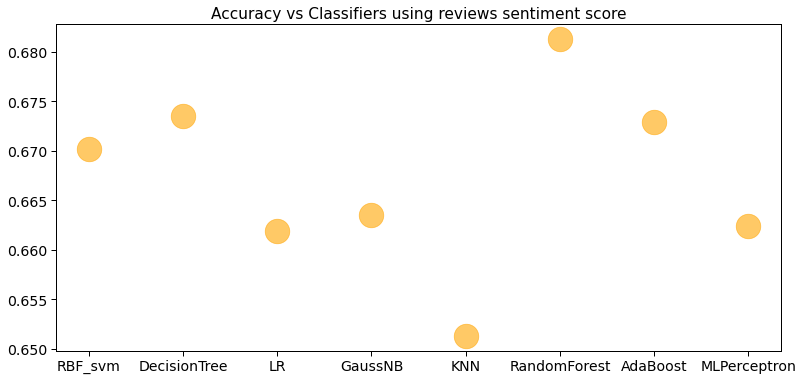

In [42]:
plt.figure(figsize=(13,6))
sns.set_context("paper", font_scale=1.6)
plt.scatter(classifiers, accuracies, s=600, c="orange", alpha=0.6)
plt.title('Accuracy vs Classifiers using reviews sentiment score')
plt.show()

In [44]:
classifiers_old=classifiers
accuracies_old=accuracies

## After adding sentiment score from tips and check-ins data

In [70]:
# Scale feature check-ins
x = data[['overall_positive_sentiment_score','overall_positive_sentiment_score_tips','check-ins']]
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
# x

In [71]:
y = data[['sentiment']].values.ravel()
y

array(['neutral', 'neutral', 'positive', ..., 'positive', 'positive',
       'neutral'], dtype=object)

In [72]:
classifiers = []
accuracies = []

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## SVM using RBF kernels

In [74]:
clf = svm.SVC(kernel = 'rbf', C = 100) 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('RBF_svm')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"SVM Classifier")

Evaluations for  SVM Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.399390  0.657921  0.395733  0.705561
Test    0.386561  0.610329  0.375609  0.706208


## Decision Tree

In [75]:
clf = tree.DecisionTreeClassifier(max_depth = 5) 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('DecisionTree')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Decision Tree Classifier")

Evaluations for  Decision Tree Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.434132  0.637020  0.438589  0.715542
Test    0.412357  0.576304  0.407769  0.708980


## Logistic Regression

In [76]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('LR')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Logistic Regression")

Evaluations for  Logistic Regression
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.533859  0.541385  0.488057  0.677519
Test    0.528779  0.512056  0.482912  0.682927


## Gaussian Naive Bayes

In [77]:
clf = GaussianNB() 
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('GaussNB')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Gaussian Naive Bayes Classifier")

Evaluations for  Gaussian Naive Bayes Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.465031  0.430545  0.378971  0.648051
Test    0.485096  0.507384  0.398837  0.663526


## K-Nearest Neighbors 

In [78]:
clf = KNeighborsClassifier(n_neighbors=5)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('KNN')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"KNN Classifier")

Evaluations for  KNN Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.596854  0.638291  0.613590  0.751901
Test    0.467720  0.482231  0.472938  0.664634


## Random Forest

In [80]:
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('RandomForest')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Random Forest Classifier")

Evaluations for  Random Forest Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.393400  0.659108  0.382209  0.709125
Test    0.381564  0.503727  0.366093  0.706763


# AdaBoost

In [81]:
clf = AdaBoostClassifier()
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)


accuracy = accuracy_score(pred_test, y_test)
classifiers.append('AdaBoost')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Ada Boost Classifier")

Evaluations for  Ada Boost Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.430728  0.539345  0.443588  0.694392
Test    0.438130  0.540873  0.451939  0.708980


## Multi-layer Perceptron

In [82]:
clf = MLPClassifier(alpha=1, max_iter=1000)
clf = clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

accuracy = accuracy_score(pred_test, y_test)
classifiers.append('MLPerceptron')
accuracies.append(accuracy)
evaluation(y_train,pred_train,y_test,pred_test,"Multi-layer Perceptron Classifier")

Evaluations for  Multi-layer Perceptron Classifier
       PRECISION    RECALL  F1_SCORE  ACCURACY
Train   0.545527  0.547553  0.505975  0.682985
Test    0.549017  0.546328  0.513158  0.692350


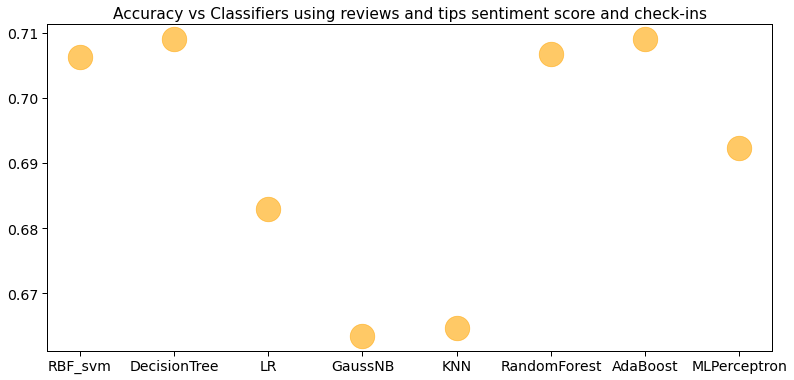

In [83]:
plt.figure(figsize=(13,6))
sns.set_context("paper", font_scale=1.6)
plt.scatter(classifiers, accuracies, s=600, c="orange", alpha=0.6)
plt.title('Accuracy vs Classifiers using reviews and tips sentiment score and check-ins')
plt.show()

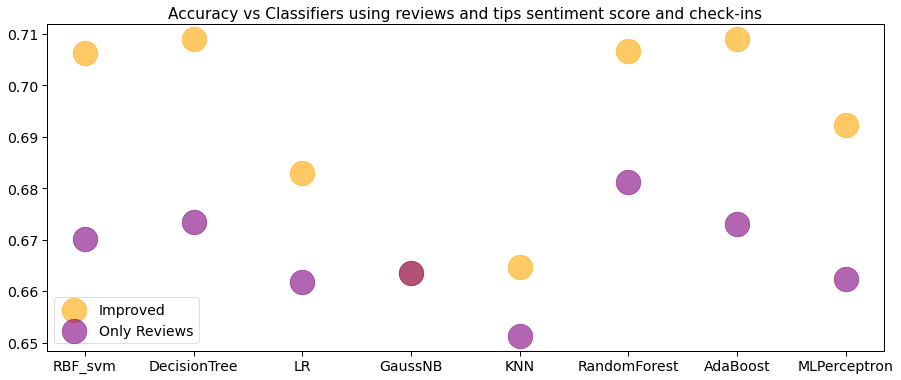

In [97]:
plt.figure(figsize=(15,6))
sns.set_context("paper", font_scale=1.6)
plt.scatter(classifiers, accuracies, s=600, c="orange", alpha=0.6)
plt.scatter(classifiers_old, accuracies_old, s=600, c="purple", alpha=0.6)
plt.legend(["Improved","Only Reviews"])
plt.title('Accuracy vs Classifiers using reviews and tips sentiment score and check-ins')
plt.show()